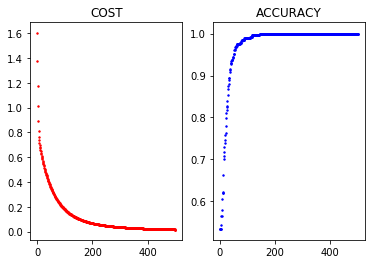

final accuracy: 1.0


In [1]:
'''
NN tested for different applications such as:
- classify a number as odd or even, giving the output in two different ways
- detect the possibility of having an heart disease given some medical data
- classify images representing handwritten digits.


basic version (no regularization, no clever weight inizialization)
'''

################################ libraries:

import numpy as np
import math
import random
import matplotlib.pyplot as plt


################################ cost and activation functions:

# cost functions:

class quadratic_cost:
    def fn(outputs,labels):
        return 0.5*np.linalg.norm(outputs-labels)**2  # 0.5 * (two_norm)^2
    
    def delta_L(outputs,labels,z_L,activation_function): # returns the delta error of the output layer
        nabla_aC = np.add(outputs, -labels) 
        sigma_der = np.array([activation_function.derivative(z_L_i) for z_L_i in z_L])
        delta = np.multiply(nabla_aC, sigma_der)
        return delta
        

class cross_entropy_cost:
    def fn(outputs,labels):
        return np.sum(np.nan_to_num(-labels*np.log(outputs)-(1-labels)*np.log(1-outputs)))
    
    def delta_L(outputs,labels,z_L,activation_function):  # returns the delta error of the output layer
        return np.add(outputs, -labels)
       
# activation functions:

class sigmoid:
    def fn(z):
        return 1.0 /(1.0 + math.exp(-z))
    def derivative(z):
        return  sigmoid.fn(z)*(1-sigmoid.fn(z))


################################ Neural Network definition:        


class NN:
    def __init__(self, layer_dimensions):
        
        self.L = len(layer_dimensions)
        self.weights = [ np.random.randn(layer_dimensions[ i + 1 ], layer_dimensions[i]) for i in range(self.L - 1) ]
        self.biases = [ np.random.randn(layer_dimensions[ i + 1 ]) for i in range(self.L - 1) ]
        self.z = [ np.zeros(b.shape) for b in self.biases ]
        self.deltas = [ np.zeros(b.shape) for b in self.biases ]
        self.activations = [ np.zeros(layer_dimensions[i]) for i in range(self.L) ]
        self.dC_dW = [ np.zeros(W.shape) for W in self.weights ]

     
    def compute_mean_cost(self,dataset,cost_function, activation_function):
        mean_cost = 0
        for ex in dataset:
                self.feedforward(ex[0],activation_function)
                self.activations[-1]=np.array(self.activations[-1])
                cost = cost_function.fn(self.activations[-1],ex[1])
                mean_cost += cost
        mean_cost /= len(dataset)
        return mean_cost
    
 
    def compute_mean_accuracy(self,dataset,activation_function):
        mean_accuracy = 0
        for ex in dataset:
                self.feedforward(ex[0], activation_function)
                output = self.activations[-1]
                output = np.array(output)
                if len(output)==1:
                    output = output >0.5
                    accuracy = np.mean(output == ex[1])
                else:
                    accuracy = np.mean(np.argmax(output)==np.argmax(ex[1]))
                mean_accuracy += accuracy
        mean_accuracy /= len(dataset)
        return mean_accuracy
    
   
    def learning(self, training_dataset, test_dataset, batch_size = 1, learning_rate = 0.1 , n_epoches = 10, activation_function=sigmoid, cost_function = quadratic_cost):
        
        #compute cost and accuracy before learning:
        cost=[]
        cost.append(self.compute_mean_cost(training_dataset, cost_function,activation_function))
        accuracy=[]
        accuracy.append(self.compute_mean_accuracy(test_dataset,activation_function))
        
        #start learning:
        epoch = 1
        while (epoch <= n_epoches):    
            
            
            training_dataset = np.random.permutation(training_dataset) #in order to create different batches at each epoch
            batches = [ training_dataset[i:i+batch_size] for i in range(0, len(training_dataset), batch_size) ]
            
            for batch in batches:  # for each batch
                
                mean_dC_dW = [ np.zeros(W.shape) for W in self.weights ]
                mean_dC_db = [ np.zeros(b.shape) for b in self.biases ]
                
                for ex in batch: # for each training example
                    
                    self.feedforward(ex[0],activation_function)
                    self.backprop(ex[1], cost_function,activation_function)
  
                    mean_dC_dW = [np.add(mean_dC_dW[l], self.dC_dW[l]) for l in range(len(self.dC_dW)) ]
                    mean_dC_db = [np.add(mean_dC_db[l], self.deltas[l]) for l in range(len(self.deltas)) ]
                    
                # update weights:
                self.weights = [ np.add(self.weights[l], -1*(mean_dC_dW[l]*learning_rate)/batch_size) for l in range(len(self.weights)) ]              
                # update biases:
                self.biases = [ np.add(self.biases[l], -1*(mean_dC_db[l]*learning_rate)/batch_size) for l in range(len(self.biases)) ]  
            
            # compute results:
            cost.append(self.compute_mean_cost(training_dataset, cost_function, activation_function))   
            accuracy.append(self.compute_mean_accuracy(test_dataset, activation_function))
            epoch+=1
        
        
        # show results:
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.scatter(range(len(cost)), cost, color='r', s=2)
        ax1.set_title("COST")
        ax2.scatter(range(len(accuracy)), accuracy, color='b', s=2)
        ax2.set_title("ACCURACY")
        plt.show()
        print("final accuracy:", accuracy[-1])

            
    def feedforward(self,input_data, activation_function):
        
        self.activations[0] = input_data
        
        for l in range(self.L-1):

            self.z[l] = np.add( np.dot(self.weights[l],self.activations[l]), self.biases[l])
            self.activations[l+1] = [activation_function.fn(z_l_i) for z_l_i in self.z[l] ]
    
    

    def backprop(self, labels, cost_function, activation_function):
        
        # BP1: to cmpute the delta_error at the output layer = delta_L = 𝛿_L =∇_𝑎𝐶 ⊙ 𝜎'(𝑧_𝐿) 
        
        self.deltas[-1] = cost_function.delta_L(self.activations[-1],labels, self.z[-1], activation_function)
        

        # BP2: to backpropagate the error and compute delta_error at each level = delta_l = 𝛿_l = ( 𝑊_(l+1)*𝛿_(l+1) ) ⊙ 𝜎′(𝑧_𝑙):
        for l in range(2,self.L):
            
            
            W_times_delta = np.dot(np.transpose(self.weights[-l+1]), self.deltas[-l+1])
            

            sigma_der = np.array([activation_function.derivative(z_l_i) for z_l_i in self.z[-l]])


            self.deltas[-l] = np.multiply(W_times_delta, sigma_der)
                  
            
        # BP3: states that dC/db is exactly delta. 
        # So i don't need to do further computation
        
        
        # BP4: states that dC/dw_l = 𝛿_l(a(l-1))^T:
        for l in range(1,self.L):
            
            self.dC_dW[-l] = np.dot(np.expand_dims(self.deltas[-l],axis=1),np.expand_dims(self.activations[-l-1],axis=0))
            


################################ Datasets:

# data= 0 odd-even ill-posed problem dataset  data=1 to use the odd-even number dataset
# data=2 to use the heartdisease dataset    # data=3 to use handwritten digit images


def create_sets(data,n_ex):

    if data == 0: # data= 0 odd-even ill-posed problem dataset
        
        n = n_ex #number of dataset examples
        n_in=1 #number of input neurons
        n_out=1 #number of output neurons

        dataset = [[np.array([num/100]),np.array(num%2)] for num in np.random.randint(1,10, size=n)]

    
    if data == 1:  # data=1 to use the odd-even number dataset
        
        n = n_ex   #number of dataset examples
        n_in=10 #number of input neurons = maximum number value which can be given as input
        n_out=2  #number of output neurons

        numbers = np.random.randint(1,n_in, size=n)
        training_inputs = []
        training_labels = []
        for num in numbers:   # simple binary codification: 3 corresponds to [ 0,0,1,...]
            inp = np.zeros(n_in)
            out = np.zeros(n_out)
            inp[num-1]=1
            out[num%2]=1
            training_inputs.append(inp)
            training_labels.append(out)

        dataset = np.array([[training_inputs[i],training_labels[i]] for i in range(len(training_labels))])

    if data == 2:  # data=2 to use the heartdisease dataset
        import pandas as pd
        dataset=pd.read_csv("heart.csv");

        n = dataset.shape[0]      # number of data examples: 303 max
        n_in = dataset.shape[1]   #number of input neurons
        n_out=1                   #number of output neurons
        
    
        inputs=dataset.iloc[:,:n_in]
        #since the dataset contains only positive values I can normalize it dividing each column by the maximum value of each column.:
        inputs = inputs / inputs.max()
        labels=dataset.iloc[:,-1]
        dataset = [[np.array(inputs.iloc[i]), np.array(labels.iloc[i])] for i in range(n)]


    
    if data == 3: # data=3 to use handwritten digit images
        
        n=n_ex      # max=45000
        n_in=784     #number of input neurons
        n_out=10     #number of output neurons
    
        dataset = np.load('my-mnist.npy', allow_pickle=True)

    # training and test set creation:
    dataset = np.random.permutation(dataset)
    training_dataset = dataset[:round(n-n/10)]
    test_dataset = dataset[round(n-n/10)+1:n]
    return training_dataset,test_dataset,n,n_in,n_out


################################ NN learning call:
# data= 0 odd-even ill-posed problem dataset  data=1 to use the odd-even number dataset
# data=2 to use the heartdisease dataset    # data=3 to use handwritten digit images

# to replicate random experiments:
np.random.seed(4)

training_set,test_set,n,n_in,n_out = create_sets(data=2,n_ex=1000)
net = NN([n_in,10,n_out])   
net.learning(training_set, training_set, batch_size=round(n/1), learning_rate=0.3, n_epoches = 500, activation_function = sigmoid, cost_function = cross_entropy_cost)


